In [232]:
import numpy as np
import pandas as pd
from matplotlib import pyplot

from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold,KFold,RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

In [233]:
df = pd.read_csv('dataset/battles_cleaned.csv')

In [234]:
df.head()

,name,year,battle_number,attacker_king,defender_king,attacker_1,defender_1,attacker_outcome,battle_type,major_death,...,defender_size,attacker_commander,defender_commander,summer,location,region,attacker_count,defender_count,attacker_commander_count,defender_commander_count
0,Battle of the Golden Tooth,298,1,Joffrey/Tommen Baratheon,Robb Stark,Lannister,Tully,win,pitched battle,1.0,...,4000.0,Jaime Lannister,"Clement Piper, Vance",1.0,Golden Tooth,The Westerlands,1,1,1,2
1,Battle at the Mummer's Ford,298,2,Joffrey/Tommen Baratheon,Robb Stark,Lannister,Baratheon,win,ambush,1.0,...,120.0,Gregor Clegane,Beric Dondarrion,1.0,Mummer's Ford,The Riverlands,1,1,1,1
2,Battle of Riverrun,298,3,Joffrey/Tommen Baratheon,Robb Stark,Lannister,Tully,win,pitched battle,0.0,...,10000.0,"Jaime Lannister, Andros Brax","Edmure Tully, Tytos Blackwood",1.0,Riverrun,The Riverlands,1,1,2,2
3,Battle of the Green Fork,298,4,Robb Stark,Joffrey/Tommen Baratheon,Stark,Lannister,loss,pitched battle,1.0,...,20000.0,"Roose Bolton, Wylis Manderly, Medger Cerwyn, H...","Tywin Lannister, Gregor Clegane, Kevan Lannist...",1.0,Green Fork,The Riverlands,1,1,5,4
4,Battle of the Whispering Wood,298,5,Robb Stark,Joffrey/Tommen Baratheon,Stark,Lannister,win,ambush,1.0,...,6000.0,"Robb Stark, Brynden Tully",Jaime Lannister,1.0,Whispering Wood,The Riverlands,2,1,2,1


In [235]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: le.fit_transform(x.astype(str)))
df.drop(columns=['battle_number','name','region','attacker_commander','defender_commander'],inplace=True)

In [236]:
y = df['attacker_outcome']
X = df.drop(columns='attacker_outcome')

In [237]:
np.random.seed(42)

In [238]:
scaler = StandardScaler()

impute_estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0)
imputer = IterativeImputer(random_state=0, estimator=impute_estimator)

cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

classifier = [
    RandomForestClassifier(),
    SVC(),
    XGBClassifier(),
    KNeighborsClassifier()
]

scores = pd.DataFrame()
for cf in classifier:
    model = make_pipeline(scaler,imputer,cf)
    scores[cf.__class__.__name__] = cross_val_score(model, X,y, scoring='f1', cv=cv, n_jobs=-1)
#     print(cf.__class__.__name__, scores[cf.__class__.__name__].mean())
#
f1_scores = pd.concat([scores.mean(), scores.std()],
                keys=['Mean', 'STD'], axis=1
                )
f1_scores.sort_values(by='Mean',ascending=False)

,Mean,STD
RandomForestClassifier,0.986667,0.029814
XGBClassifier,0.971282,0.039491
KNeighborsClassifier,0.957949,0.038615
SVC,0.929231,0.005618


## RF Model Confusion Matrix

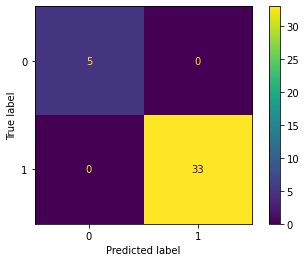

In [239]:
from sklearn.metrics import plot_confusion_matrix
np.random.seed(42)
model = make_pipeline(scaler,imputer,RandomForestClassifier())
model.fit(X,y)
plot_confusion_matrix(model, X, y) 

## RF Model Feature Importances

In [249]:
np.random.seed(42)
importance = model.named_steps['randomforestclassifier'].feature_importances_

df_imp = pd.DataFrame()
df_imp['feature'] = df.drop(columns='attacker_outcome').columns
score = []
for i,v in enumerate(importance):
    score.append(v)
df_imp['score'] = score
df_imp.sort_values(by='score',ascending=False).head()

,feature,score
14,attacker_commander_count,0.259548
8,attacker_size,0.236983
15,defender_commander_count,0.136961
11,location,0.113635
9,defender_size,0.079646
